##  Домашнее задание № 5: Пироги с глазами!

Задание присылать на обе почты почты aleksartamonov@gmail.com dashkov.alexander.om@gmail.com в виде ссылки на colab

В теме письма указать **CV_HSE_2021 HW5 <Фамилия Имя>**

soft deadline: 02.06.2021T23:59:00+0300

hard deadline: 09.06.2021T23:59:00+0300

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive


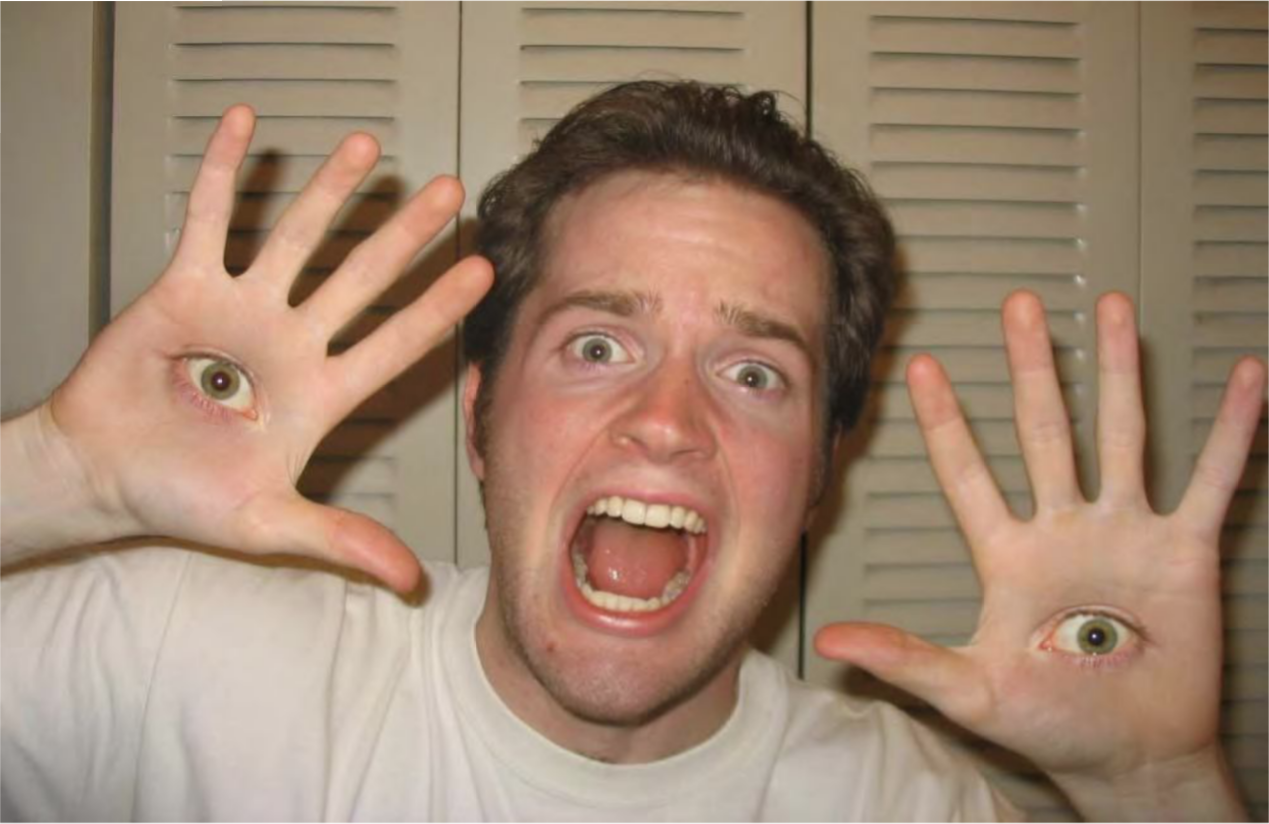

In [2]:
from __future__ import print_function
import cv2, os, torch, torch.optim
from cv2 import pyrDown, pyrUp, subtract, add
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Пирамида лапласа
**(15 баллов)** Используя прием сшивки изображений с помощью пирамиды Лапласа, повторите прием с вашими глазами и вашими руками (или сделайте что-то похожее по смыслу)

In [3]:
# https://becominghuman.ai/image-blending-using-laplacian-pyramids-2f8e9982077f
def get_mask(center, axes_length, size):
  return cv2.ellipse(np.zeros(size), tuple(center), tuple(axes_length), 0, 0, 
                     360, color=(255,255,255), thickness=-1)

def get_gauss_pyramid(src, depth):
  pyramid = [src.copy().astype(float)]
  for _ in range(depth):
    pyramid.append(pyrDown(pyramid[-1]))
  return pyramid

def get_laplace_pyramid(gauss_pyramid):
  depth = len(gauss_pyramid) - 1
  pyramid = [gauss_pyramid[depth]]
  for i in range(depth, 0, -1):
    pyramid.append(subtract(gauss_pyramid[i - 1], pyrUp(gauss_pyramid[i])))
  return pyramid

def restore_src(laplace_pyramid):
  out = laplace_pyramid[0].copy()
  for el in laplace_pyramid[1:]:
    el = el.astype(float)
    out = add(pyrUp(out), el)
  return out            

def copy_src_to_dst_by_masks(img, src_mask, dst_mask):
  img_ = img.copy()
  img_[dst_mask != 0] = img_[src_mask != 0].copy() 
  return img_

In [4]:
# Your code here
src = cv2.imread(cv2.samples.findFile('photo.jpg'))

In [5]:
top, left = 105, 315
bottom, right = 135, 395
eye = src[top:bottom, left:right]  # правый глазик
cv2_imshow(eye)


вообще тут мешаются брови, чтобы чуть-чуть больше захватить кожи сверху, но они дововольно яркие, поэтому не очень удалось их скрыть :(((

Вывод: не надо хмуриться!

In [6]:
center_src = np.array(((left + right) // 2 , (top + bottom) // 2))
ellipse_axis = np.array(((right - left) // 2 , (bottom - top) // 2))

# source mask
src_msk = cv2.ellipse(np.zeros_like(src), tuple(center_src), tuple(ellipse_axis), 
                      0, 0, 360, color=(255, 255, 255), thickness=-1)

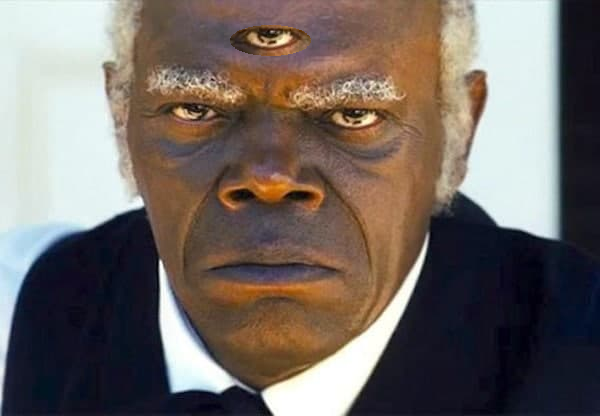

In [7]:
center_dst = np.array((270, 40))
offset = center_src - center_dst

# destination mask
dst_msk = cv2.ellipse(np.zeros_like(src), tuple(center_src - offset), 
                      tuple(ellipse_axis), 0, 0, 360, color=(255, 255, 255), 
                      thickness=-1)

src_msk = get_mask(center_src, ellipse_axis, src.shape)
dst_msk = get_mask(center_src-offset, ellipse_axis, src.shape)

mayonnaise_slap = copy_src_to_dst_by_masks(src, src_msk, dst_msk)
cv2_imshow(mayonnaise_slap)

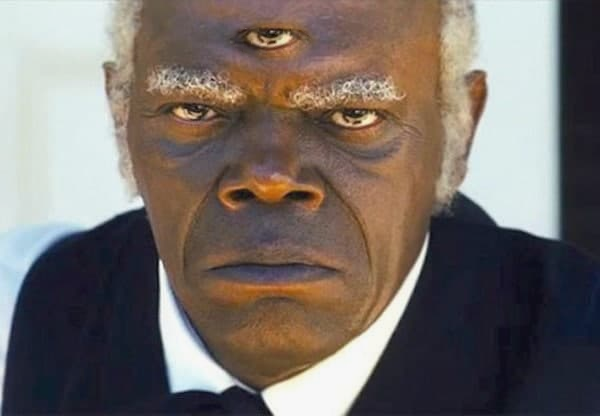

In [8]:
depth = min(np.log2(ellipse_axis).astype(int))
pyramid_src = get_laplace_pyramid(get_gauss_pyramid(src, depth))

mix = []

for i, src_ in enumerate(pyramid_src[::-1]):
  n = 2 ** i  # assuming masks are halfly moved/resized with pyr level
  center_dst = center_src-offset

  center_src_ = np.round(center_src / n).astype(int)  # О да, классика, не забыть про type
  center_dst_ = np.round((center_src - offset) / n).astype(int)
  ellipse_axis_ = np.round(ellipse_axis / n).astype(int)

  size = (src.shape[0] // n, src.shape[1] // n, 3)
  
  eye_src = get_mask(center_src_, ellipse_axis_, size)
  eye_dst = get_mask(center_dst_, ellipse_axis_, size)

  mix.append(copy_src_to_dst_by_masks(src_, eye_src, eye_dst))

res = restore_src(mix[::-1])
res = 255 * (res - res.min()) / (res.max() - res.min())
cv2_imshow(res)

Поигравшись с размером вырезанного глазика, в целом, вышло неплохо, не смотря на некую зашакаленность исходной картинки.

### Deep Image Prior
**(15 баллов)** Используя подход [Deep Image Prior](https://github.com/DmitryUlyanov/deep-image-prior) и его способность восстанавливать изображения, повторите прием с вашими глазами и вашими руками (или сделайте что-то похожее по смыслу)

In [9]:
!git clone https://github.com/DmitryUlyanov/deep-image-prior
%cd deep-image-prior
from models.resnet import ResNet
from models.unet import UNet
from models.skip import skip
from utils.inpainting_utils import *

fatal: destination path 'deep-image-prior' already exists and is not an empty directory.
/gdrive/MyDrive/deep-image-prior


In [10]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
dtype = torch.cuda.FloatTensor

PLOT = True
imsize = -1
dim_div_by = 64

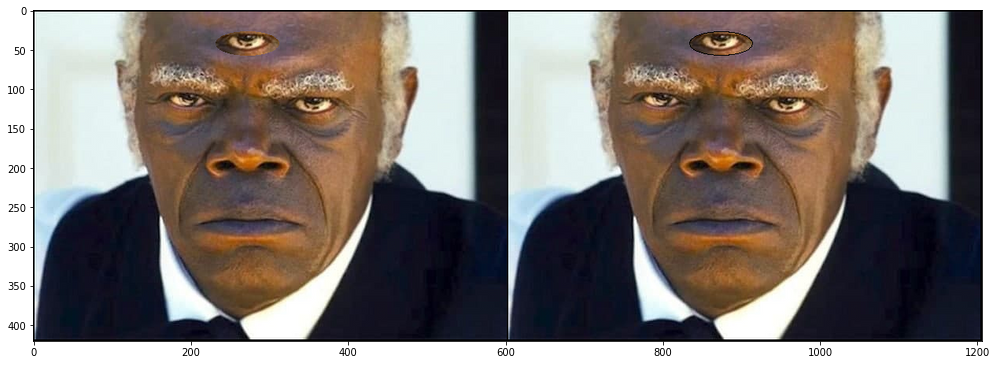

In [11]:
img = mayonnaise_slap[:,:,::-1].transpose(2, 0, 1) / 255

img_mask = (255 - cv2.ellipse(np.zeros_like(mayonnaise_slap), tuple(center_dst), 
                              tuple(ellipse_axis), 0, 0, 360, 
                              color=(255, 255, 255), thickness=1)) / 255
img_mask = img_mask.transpose(2, 0, 1)

plot_image_grid([img, img_mask * img], 3, 15);

In [12]:
pad = 'reflection' # 'zero'
OPT_OVER = 'net'
OPTIMIZER = 'adam'
INPUT = 'noise'
input_depth = 1
show_every = 300
figsize = 8
reg_noise_std = 0.00
param_noise = True
LR = 0.01 

In [13]:
net = skip(input_depth).type(dtype)
net_input = get_noise(input_depth, INPUT, img.shape[1:]).type(dtype)

In [14]:
mse = torch.nn.MSELoss().type(dtype)

img_var = np_to_torch(img).type(dtype)
mask_var = np_to_torch(img_mask).type(dtype)

Starting optimization with ADAM


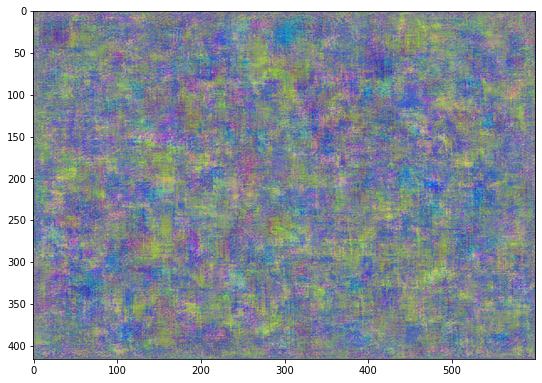

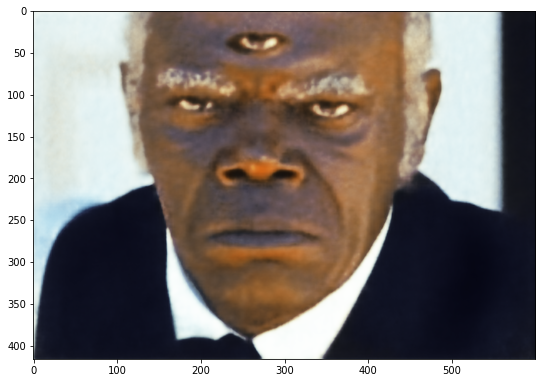

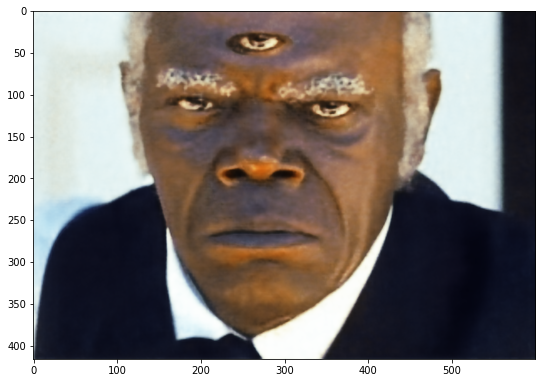

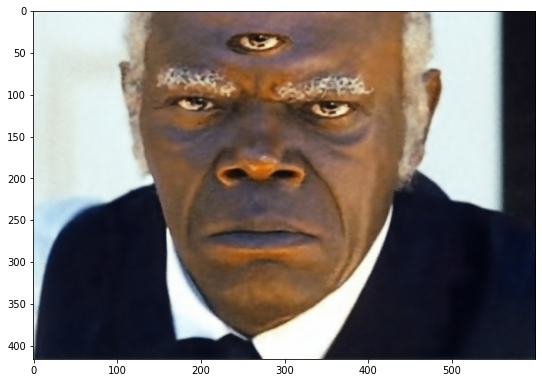

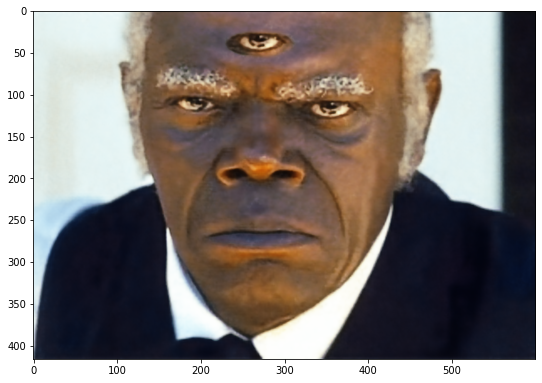

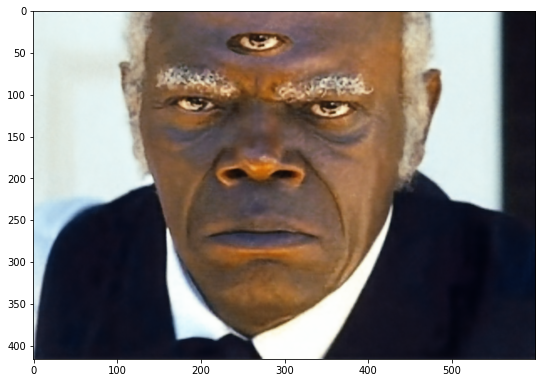

In [ ]:
i = 0
def closure():
    global i
    if param_noise:
        for n in [x for x in net.parameters() if len(x.size()) == 4]:
            n = n + n.detach().clone().normal_() * n.std() / 50
    
    net_input = net_input_saved
    # print(net_input.shape)
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    
    # print(net_input.shape)

    out = net(net_input)
    # print(out.shape)
    total_loss = mse(out * mask_var, img_var * mask_var)
    total_loss.backward()
        
    print('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
    if  PLOT and i % show_every == 0:
        out = torch_to_np(out)
        plot_image_grid([np.clip(out, 0, 1)], factor=figsize, nrow=1)
        
    i += 1

    return total_loss

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter=3001)

In [ ]:
res_skip = torch_to_np(net(net_input))

In [ ]:
plot_image_grid([img, res_skip, res[:, :, ::-1].transpose(2, 0, 1) / 255], 1, 10);

# Appendix
Надо поработать лучше над глазиком, попробуем его вырезать более точечно.

In [ ]:
%cd /gdrive/MyDrive

In [ ]:
src = cv2.imread(cv2.samples.findFile('photo.jpg'))

top, left = 105, 327
bottom, right = 130, 385
eye = src[top:bottom, left:right]  # правый глазик
cv2_imshow(eye)

center_src = np.array(((left + right) // 2 , (top + bottom) // 2))
ellipse_axis = np.array(((right - left) // 2 , (bottom - top) // 2))

# source mask
src_msk = cv2.ellipse(np.zeros_like(src), tuple(center_src), tuple(ellipse_axis), 
                      0, 0, 360, color=(255, 255, 255), thickness=-1)
# cv2_imshow(src_msk)

center_dst = np.array((270, 40))
offset = center_src - center_dst

# dsitanation mask
dst_msk = cv2.ellipse(np.zeros_like(src), tuple(center_src - offset), 
                      tuple(ellipse_axis), 0, 0, 360, color=(255, 255, 255), 
                      thickness=-1)
# cv2_imshow(eye_dst)

src_msk = get_mask(center_src, ellipse_axis, src.shape)
dst_msk = get_mask(center_src-offset, ellipse_axis, src.shape)

mayonnaise_slap = copy_src_to_dst_by_masks(src, src_msk, dst_msk)
cv2_imshow(mayonnaise_slap)

img = mayonnaise_slap[:, :, ::-1].transpose(2, 0, 1) / 255

img_mask = (255 - cv2.ellipse(np.zeros_like(mayonnaise_slap), tuple(center_dst), 
                                 tuple(ellipse_axis), 0, 0, 360, 
                                 color=(255, 255, 255), thickness=1)) / 255
img_mask = img_mask.transpose(2, 0, 1)

plot_image_grid([img, img_mask * img], 3, 15);

In [ ]:
net = skip(input_depth).type(dtype)

LR = 0.01 

net = net.type(dtype)
net_input = get_noise(input_depth, INPUT, img.shape[1:]).type(dtype)

In [ ]:
mse = torch.nn.MSELoss().type(dtype)

img_var = np_to_torch(img).type(dtype)
mask_var = np_to_torch(img_mask).type(dtype)

In [ ]:
i = 0
def closure():
    global i
    if param_noise:
        for n in [x for x in net.parameters() if len(x.size()) == 4]:
            n = n + n.detach().clone().normal_() * n.std() / 50
    
    net_input = net_input_saved
    # print(net_input.shape)
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    
    # print(net_input.shape)

    out = net(net_input)
    # print(out.shape)
    total_loss = mse(out * mask_var, img_var * mask_var)
    total_loss.backward()
        
    print('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
    if  PLOT and i % show_every == 0:
        out = torch_to_np(out)
        plot_image_grid([np.clip(out, 0, 1)], factor=figsize, nrow=1)
        
    i += 1

    return total_loss

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter=3001)

In [ ]:
res_skip = torch_to_np(net(net_input))

In [ ]:
plot_image_grid([img, res_skip, res[:, :, ::-1].transpose(2, 0, 1) / 255], 1, 10);

Ай, все равно не оч получается, как будто у него глаз выгрызается из лба. Может можно как-то с шумом поиграться, со слоями сетки, но к этому моменту я уже поседели, полысел, снова поседел и усталь :с

В итоге вывод: ваще домашка прикольная, миксить пирамиды субъективно выглядит лучше на этом примере, да и с сеткой я не очень прям уж чтобы много игрался, оставил два варианта: 1) для исходного глаза и 2) для более точечного в качестве демонстрации. По крайней мере с помощью пирамидок получается более ествественный (если так можно сказать) результат.